In [1]:
import os
from pathlib import Path
import re
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Tuple
from datetime import datetime
import math
from math import log, sqrt, exp
from math import erf

### PART 1: Collection, Preprocessing, EDA

In [2]:
# Understanding raw data set
# --- 1) Define directories ---
RTH_DIR = Path('./RTH')
ETH_DIR = Path('./ETH')

# --- 2) List CSVs only (ignore hidden files like .DS_Store) ---
csv_in_RTH = sorted([p.name for p in RTH_DIR.glob('*.csv')])
csv_in_ETH = sorted([p.name for p in ETH_DIR.glob('*.csv')])

print("Inside RTH folder:\n", [f.replace('.csv','') for f in csv_in_RTH[0:9]])
print("\nInside ETH folder:\n", [f.replace('.csv','') for f in csv_in_ETH[0:9]])

# View first few lines of each file in the folder (RTH or ETH)
pd.set_option('display.max_columns', None) # Optional: show all columns when printing heads

DATE_FILE_RE = re.compile(r'(\d{4}-\d{2}-\d{2})_.*\.csv$')

def group_by_date(filenames):
    groups = defaultdict(list)
    for name in filenames:
        m = DATE_FILE_RE.match(name)
        date = m.group(1) if m else 'UNKNOWN_DATE'
        groups[date].append(name)
    # sort by date string
    return dict(sorted(groups.items(), key=lambda kv: kv[0]))

def print_sample_heads(folder: Path, filenames, per_date=5, rows=3):
    groups = group_by_date(filenames)
    for date, files in groups.items():
        print(f"\n===== {date} (showing up to {per_date} files) =====")
        for file in sorted(files)[:per_date]:
            try:
                df = pd.read_csv(folder / file, nrows=rows)
                print(f"\n{file} — first {rows} rows")
                print(df)
            except Exception as e:
                print(f"[ERROR] {file}: {e}")

# RTH preview: first 3 rows of up to 5 files per date
print_sample_heads(RTH_DIR, csv_in_RTH[0:9], per_date=5, rows=3)

Inside RTH folder:
 ['2025-04-01_assets', '2025-04-01_call_ask_20250416', '2025-04-01_call_bid_20250416', '2025-04-01_put_ask_20250416', '2025-04-01_put_bid_20250416', '2025-04-02_assets', '2025-04-02_call_ask_20250416', '2025-04-02_call_bid_20250416', '2025-04-02_put_ask_20250416']

Inside ETH folder:
 ['2025-04-01_assets', '2025-04-01_call_ask_20250416', '2025-04-01_call_bid_20250416', '2025-04-01_put_ask_20250416', '2025-04-01_put_bid_20250416', '2025-04-02_assets', '2025-04-02_call_ask_20250416', '2025-04-02_call_bid_20250416', '2025-04-02_put_ask_20250416']

===== 2025-04-01 (showing up to 5 files) =====

2025-04-01_assets.csv — first 3 rows
                   Unnamed: 0      SPX   ES_BID   ES_ASK    VIX
0  2025-04-01 09:31:21.491248  5590.32  5631.75  5632.00  22.66
1  2025-04-01 09:31:24.535800  5590.70  5631.75  5632.00  22.66
2  2025-04-01 09:31:27.582698  5589.06  5629.50  5629.75  22.66

2025-04-01_call_ask_20250416.csv — first 3 rows
                   Unnamed: 0  4600.0  4

In [3]:
# Optional if want to view time in your own timezone
SOURCE_TZ  = "America/New_York"         # your CSV
TARGET_TZ  = "America/New_York"         # <- keep RTH time on output bins
# TARGET_TZ = "UTC"                     # <- use this if you prefer UTC

# ==================================
# SECTION 1 — Loader & Resample Utils
# ==================================

def _read_any(path: Path) -> pd.DataFrame:
    """Read CSV or Parquet based on suffix; CSV default."""
    if path.suffix.lower() == ".parquet":
        try:
            return pd.read_parquet(path)
        except Exception:
            # fall back to CSV with same stem, if exists
            alt = path.with_suffix(".csv")
            return pd.read_csv(alt) if alt.exists() else pd.read_csv(path)
    return pd.read_csv(path)

def parse_timestamp_col(
    df: pd.DataFrame,
    col: str = "Unnamed: 0",
    tz=None,                      # accepts None, "America/New_York", or ("America/New_York","UTC")
    source_tz: str = None,        # new-style explicit args also supported
    target_tz: str = None,
):
    """
    Backward-compatible timestamp parser:
    - If tz is a tuple/list: (source_tz, target_tz)
    - If tz is a string: interpreted as source_tz; target_tz = same (no convert)
    - Else: use explicit source_tz/target_tz args if provided
    """
    # Resolve source/target based on inputs
    if tz is not None:
        if isinstance(tz, (tuple, list)) and len(tz) == 2:
            source_tz, target_tz = tz[0], tz[1]
        elif isinstance(tz, str):
            source_tz = tz
            target_tz = tz  # keep in same tz by default
        else:
            raise TypeError("tz must be None, a string, or a (source_tz, target_tz) tuple")

    if col not in df.columns:
        raise ValueError(f"Timestamp column '{col}' not found. Got: {list(df.columns)[:8]}...")

    ts = pd.to_datetime(df[col], errors="coerce")

    # Localize and/or convert
    if source_tz:
        ts = ts.dt.tz_localize(source_tz, nonexistent="NaT", ambiguous="NaT")
    else:
        # If no source specified, assume naive times are already UTC
        ts = ts.dt.tz_localize("UTC")

    if target_tz and target_tz != source_tz:
        ts = ts.dt.tz_convert(target_tz)

    return df.drop(columns=[col]).assign(timestamp=ts)


# ---------- ASSETS ----------
def load_assets(path: Path, tz: str = SOURCE_TZ) -> pd.DataFrame:
    """
    Expects columns like: Unnamed: 0 (timestamp), SPX, ES_BID, ES_ASK, VIX
    Returns a tidy frame ready for resample.
    """
    df = _read_any(path)
    df = parse_timestamp_col(df, col="Unnamed: 0", tz=tz)
    # Keep only numeric asset columns + timestamp
    keep = ["timestamp"] + [c for c in df.columns if c != "timestamp"]
    return df[keep]

def resample_assets_ohlc(df_assets: pd.DataFrame, interval: str, session: str) -> pd.DataFrame:
    out = []
    for col in [c for c in df_assets.columns if c != "timestamp"]:
        g = df_assets[["timestamp", col]].dropna().sort_values("timestamp").set_index("timestamp")
        o = pd.DataFrame({
            "open":  g[col].resample(interval).first(),
            "high":  g[col].resample(interval).max(),
            "low":   g[col].resample(interval).min(),
            "close": g[col].resample(interval).last(),
            "last":  g[col].resample(interval).last(),
            "median": g[col].resample(interval).median(),  # robust rep
        }).reset_index().rename(columns={"timestamp":"timestamp_bin"})
        o["symbol"] = col
        out.append(o)
    out = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
    if not out.empty:
        out["session"] = session
    return out


# ---------- OPTIONS (wide -> long -> resample) ----------
def load_option_wide(path: Path, option_type: str, side: str, tz: str = SOURCE_TZ) -> pd.DataFrame:
    """
    Reads your 'wide' strike matrix, cleans, and returns a LONG table:
      timestamp | strike | price | option_type | side | expiry
    Treats -1.0 or <= -0.9999 as missing quotes.
    """
    df = _read_any(path)
    df = parse_timestamp_col(df, col="Unnamed: 0", tz=tz)
    strike_cols = [c for c in df.columns if c != "timestamp"]
    # Force numeric and drop placeholders like -1.0
    for c in strike_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df.loc[df[c] <= -0.9999, c] = np.nan

    long = df.melt(id_vars=["timestamp"], var_name="strike", value_name="price")
    long["strike"] = pd.to_numeric(long["strike"], errors="coerce")
    long = long.dropna(subset=["timestamp", "strike"])
    long["option_type"] = option_type
    long["side"] = side
    long["expiry"] = EXPIRY
    return long

def resample_options(
    long_df: pd.DataFrame,
    interval: str,
    clip_q: Optional[Tuple[float, float]] = (0.005, 0.995),
) -> pd.DataFrame:
    """
    Resample a single side+type to the interval:
      -> mean, median, last per (strike, bar)
    Optional clip_q=(low, high) winsorizes raw prices within each strike.
    """
    g = long_df.sort_values("timestamp").set_index("timestamp")

    # Optional: winsorize within each strike before resampling
    if clip_q is not None:
        low_q, high_q = clip_q
        def _clip_grp(x: pd.Series):
            lo, hi = x.quantile([low_q, high_q])
            return x.clip(lo, hi)
        g["price"] = g.groupby("strike")["price"].transform(_clip_grp)

    agg = g.groupby("strike")["price"].resample(interval).agg(["mean", "median", "last"]).reset_index()
    agg = agg.rename(columns={"timestamp": "timestamp_bin", "mean": "avg", "median": "med", "last": "last"})
    agg["option_type"] = long_df["option_type"].iloc[0]
    agg["side"]       = long_df["side"].iloc[0]
    agg["expiry"]     = long_df["expiry"].iloc[0]
    return agg

def merge_bid_ask(call_bid, call_ask, put_bid, put_ask, session: str) -> pd.DataFrame:
    # Rename so we keep both mean & median from each side
    cb = call_bid.rename(columns={"avg":"bid_avg", "med":"bid_med", "last":"bid_last"})
    ca = call_ask.rename(columns={"avg":"ask_avg", "med":"ask_med", "last":"ask_last"})
    pb = put_bid.rename(columns={"avg":"bid_avg", "med":"bid_med", "last":"bid_last"})
    pa = put_ask.rename(columns={"avg":"ask_avg", "med":"ask_med", "last":"ask_last"})

    def combine(one_bid, one_ask, opt_type):
        df = pd.merge(
            one_bid[["timestamp_bin","strike","bid_avg","bid_med","bid_last"]],
            one_ask[["timestamp_bin","strike","ask_avg","ask_med","ask_last"]],
            on=["timestamp_bin","strike"], how="outer"
        )

        # Backward-compatible columns (always compute both)
        df["mid_avg"]    = (df["bid_avg"] + df["ask_avg"]) / 2.0
        df["spread_avg"] = (df["ask_avg"] - df["bid_avg"])
        df["mid_med"]    = (df["bid_med"] + df["ask_med"]) / 2.0
        df["spread_med"] = (df["ask_med"] - df["bid_med"])

        # Unified columns driven by AGG_KIND (your downstream can just use these)
        if AGG_KIND == "median":
            df["mid"]    = df["mid_med"]
            df["spread"] = df["spread_med"]
        else:
            df["mid"]    = df["mid_avg"]
            df["spread"] = df["spread_avg"]

        df["option_type"] = opt_type
        df["expiry"] = EXPIRY
        df["session"] = session
        df["has_both"] = df["bid_avg"].notna() & df["ask_avg"].notna()
        return df

    calls = combine(cb, ca, "C")
    puts  = combine(pb, pa, "P")
    return pd.concat([calls, puts], ignore_index=True)

def write_outputs(assets_df, options_df, date: str, interval: str, session: str, out_dir: Path):
    a_path = out_dir / f"{date}_assets_{interval}_{session}.csv"
    o_path = out_dir / f"{date}_options_quotes_{interval}_{session}.csv"
    assets_df.to_csv(a_path, index=False)
    options_df.to_csv(o_path, index=False)
    print("Wrote:")
    print("  ", a_path)
    print("  ", o_path)
    # Optional Parquet (if you have pyarrow/fastparquet installed)
    # assets_df.to_parquet(a_path.with_suffix(".parquet"), index=False)
    # options_df.to_parquet(o_path.with_suffix(".parquet"), index=False)

def plot_asset_vs_vix(
    assets_agg,
    ref_symbol="SPX",            # or "ES_BID"
    date_label=None,             # e.g., DATE
    session_label=None,          # e.g., "RTH"/"ETH"
    interval_label=None,         # e.g., "30min"
    tz_display="America/New_York",
    normalize=None,              # None, "index", or "pct"
    ref_color="tab:blue",
    vix_color="tab:orange",
):
    """
    normalize:
      - None   -> raw last values; dual y-axes (ref left, VIX right)
      - "index"-> both rebased to 100 at first non-NaN (single axis)
      - "pct"  -> both as % change from first non-NaN, in percent (single axis)
    """
    # 1) local time x-axis
    df = assets_agg.copy()
    df["ts_local"] = df["timestamp_bin"].dt.tz_convert(tz_display).dt.tz_localize(None)

    # 2) select series
    ref = df[df["symbol"] == ref_symbol][["ts_local","last"]].rename(columns={"last": ref_symbol})
    vix = df[df["symbol"] == "VIX"][["ts_local","last"]].rename(columns={"last":"VIX"})
    if ref.empty:
        raise ValueError("No rows for symbol='%s' in assets_agg['symbol']." % ref_symbol)

    merged = ref.merge(vix, on="ts_local", how="outer").sort_values("ts_local")

    # 3) normalization helpers
    def _rebase(s, mode):
        s = s.astype(float)
        nz = s.dropna()
        if nz.empty:
            return s
        base = nz.iloc[0]
        if mode == "index":
            return 100.0 * (s / base)
        elif mode == "pct":
            return 100.0 * (s / base - 1.0)
        return s

    fig, ax1 = plt.subplots(figsize=(10, 4.5))

    if normalize in ("index", "pct"):
        merged[ref_symbol+"_norm"] = _rebase(merged[ref_symbol], normalize)
        if "VIX" in merged:
            merged["VIX_norm"] = _rebase(merged["VIX"], normalize)

        ylab = "Index (start=100)" if normalize == "index" else "% from start"
        ax1.plot(merged["ts_local"], merged[ref_symbol+"_norm"], label=ref_symbol, color=ref_color, linewidth=1.6)
        if "VIX_norm" in merged:
            ax1.plot(merged["ts_local"], merged["VIX_norm"], label="VIX", color=vix_color, linewidth=1.6)
        ax1.set_ylabel(ylab)
        ax1.legend(loc="best")
    else:
        l1 = ax1.plot(merged["ts_local"], merged[ref_symbol], label=ref_symbol, color=ref_color, linewidth=1.6)
        ax1.set_ylabel(f"{ref_symbol} (last)", color=ref_color)
        ax2 = ax1.twinx()
        l2 = ax2.plot(merged["ts_local"], merged["VIX"], label="VIX", color=vix_color, linewidth=1.6)
        lines = l1 + l2
        labels = [ln.get_label() for ln in lines]
        ax1.legend(lines, labels, loc="best")

    ax1.set_xlabel(f"Time ({tz_display.split('/')[-1]})")

    # Title
    bits = [b for b in [date_label, session_label, interval_label] if b]
    plt.title(f"{ref_symbol} vs VIX ({' '.join(bits)})" if bits else f"{ref_symbol} vs VIX")

    # X ticks aligned to interval if possible
    step = None
    if interval_label:
        m = re.fullmatch(r"(\d+)\s*min", interval_label.strip().lower())
        if m:
            step = int(m.group(1))
    if step and step >= 1:
        loc = mdates.MinuteLocator(interval=step)
    else:
        loc = mdates.AutoDateLocator()
    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    for lbl in ax1.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha("right")

    plt.tight_layout()
    plt.show()

In [4]:
# ========================================
# SECTION 2 — Config and Run for 1 date
# ========================================

# If you need to install (uncomment and run once):
# !pip install pandas numpy matplotlib pyarrow fastparquet

# --- USER CONFIG ---
# BASE_DIR   = r"/path/to/your/data"     # <== CHANGE ME (folder that contains RTH/ and ETH/)
BASE_DIR   = r"."     # <== CHANGE ME (folder that contains RTH/ and ETH/)
SESSION    = "RTH"                     # "RTH" or "ETH"
DATE       = "2025-04-07"              # the trade date you’re processing
INTERVAL   = "5min"                    # try "1min", "5min", "15min", "30min"
AGG_KIND   = "median"                  # "mean" for normal periods or "median" for volatile periods

# ========================================

# Output directory (created if missing)
OUT_DIR = Path(BASE_DIR) / "derived_csv"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Expected filenames (under BASE_DIR/SESSION/)
trade_dt = datetime.strptime(DATE, "%Y-%m-%d")
if trade_dt >= datetime(2025, 4, 7):
    EXPIRY = "2025-05-15"
else:
    EXPIRY = "2025-04-16"
assets_path   = Path(BASE_DIR) / SESSION / f"{DATE}_assets.csv"
call_ask_path = Path(BASE_DIR) / SESSION / f"{DATE}_call_ask_{EXPIRY.replace('-','')}.csv"
call_bid_path = Path(BASE_DIR) / SESSION / f"{DATE}_call_bid_{EXPIRY.replace('-','')}.csv"
put_ask_path  = Path(BASE_DIR) / SESSION / f"{DATE}_put_ask_{EXPIRY.replace('-','')}.csv"
put_bid_path  = Path(BASE_DIR) / SESSION / f"{DATE}_put_bid_{EXPIRY.replace('-','')}.csv"

print("Looking for:")
for p in [assets_path, call_ask_path, call_bid_path, put_ask_path, put_bid_path]:
    print(" -", p)

# 1) Load
assets_raw   = load_assets(assets_path, tz=(SOURCE_TZ, TARGET_TZ))
call_ask_long = load_option_wide(call_ask_path, "C", "ask", tz=(SOURCE_TZ, TARGET_TZ))
call_bid_long = load_option_wide(call_bid_path, "C", "bid", tz=(SOURCE_TZ, TARGET_TZ))
put_ask_long  = load_option_wide(put_ask_path,  "P", "ask", tz=(SOURCE_TZ, TARGET_TZ))
put_bid_long  = load_option_wide(put_bid_path,  "P", "bid", tz=(SOURCE_TZ, TARGET_TZ))

# 2) Resample
assets_agg   = resample_assets_ohlc(assets_raw, INTERVAL, SESSION)

# Resample each side with robust clip
call_ask_agg = resample_options(call_ask_long, INTERVAL, clip_q=(0.005, 0.995))
call_bid_agg = resample_options(call_bid_long, INTERVAL, clip_q=(0.005, 0.995))
put_ask_agg  = resample_options(put_ask_long,  INTERVAL, clip_q=(0.005, 0.995))
put_bid_agg  = resample_options(put_bid_long,  INTERVAL, clip_q=(0.005, 0.995))

# 3) Merge options sides (calls + puts)
options_tidy = merge_bid_ask(call_bid_agg, call_ask_agg, put_bid_agg, put_ask_agg, SESSION)

# 4) Save
write_outputs(assets_agg, options_tidy, DATE, INTERVAL, SESSION, OUT_DIR)

# Quick previews
print("files saved for assets and options")
print("\nColumns available for asset file")
print(assets_agg.columns)
print("\nColumns available for options file")
print(options_tidy.columns)

Looking for:
 - RTH\2025-04-07_assets.csv
 - RTH\2025-04-07_call_ask_20250515.csv
 - RTH\2025-04-07_call_bid_20250515.csv
 - RTH\2025-04-07_put_ask_20250515.csv
 - RTH\2025-04-07_put_bid_20250515.csv
Wrote:
   derived_csv\2025-04-07_assets_5min_RTH.csv
   derived_csv\2025-04-07_options_quotes_5min_RTH.csv
files saved for assets and options

Columns available for asset file
Index(['timestamp_bin', 'open', 'high', 'low', 'close', 'last', 'median',
       'symbol', 'session'],
      dtype='object')

Columns available for options file
Index(['timestamp_bin', 'strike', 'bid_avg', 'bid_med', 'bid_last', 'ask_avg',
       'ask_med', 'ask_last', 'mid_avg', 'spread_avg', 'mid_med', 'spread_med',
       'mid', 'spread', 'option_type', 'expiry', 'session', 'has_both'],
      dtype='object')


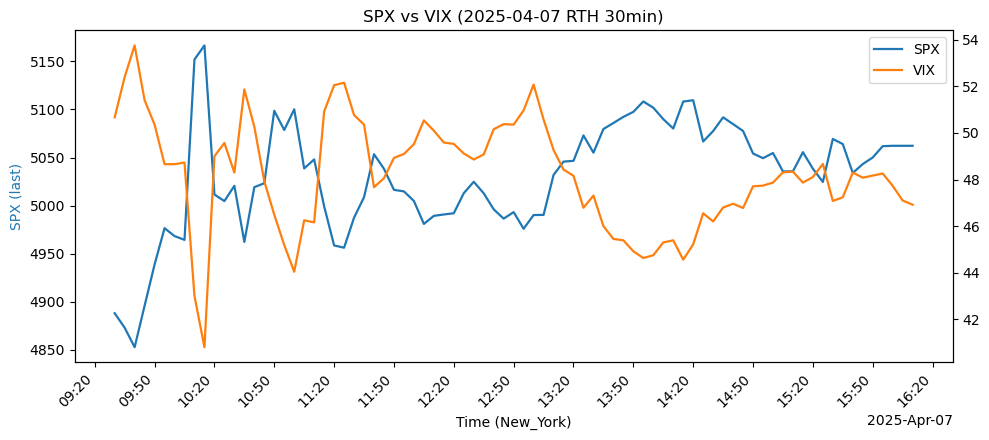

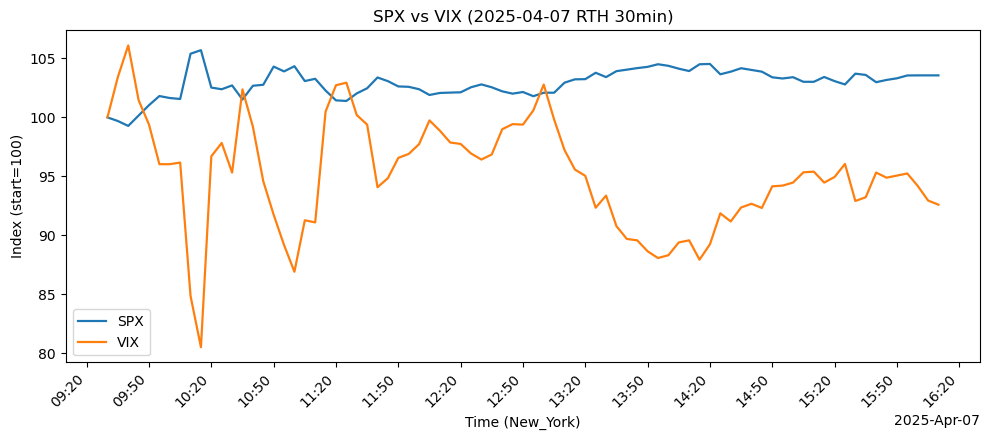

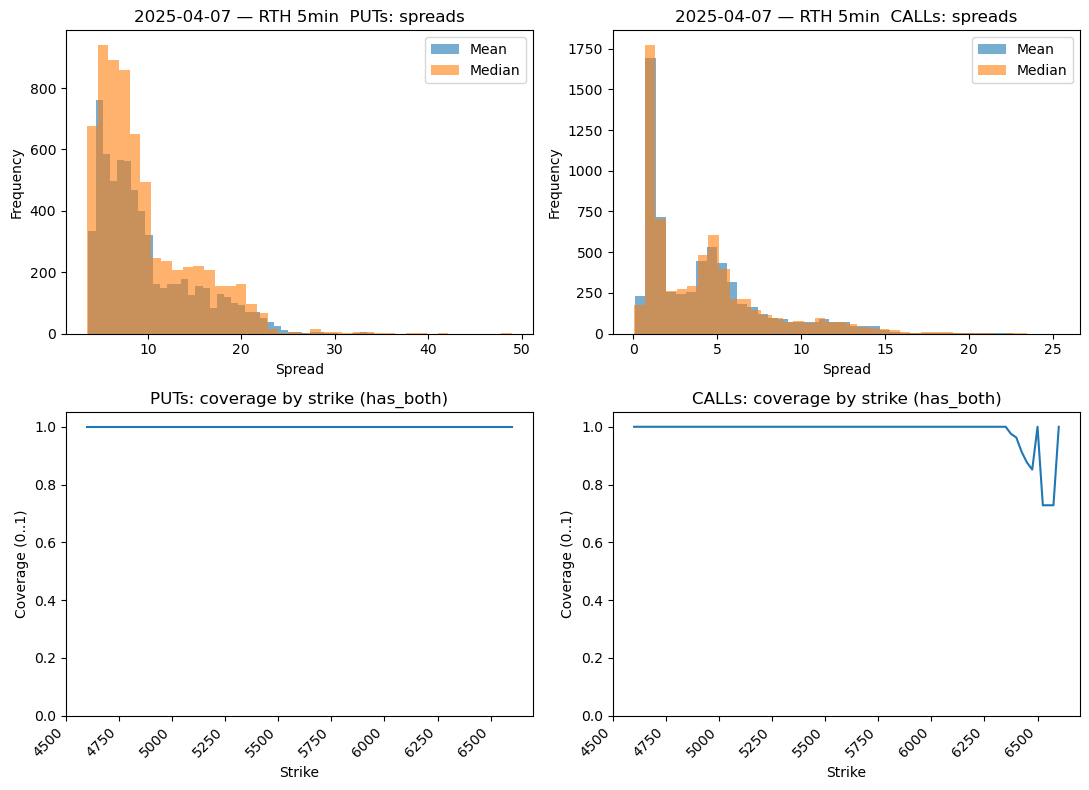

In [5]:
# ===========================
# SECTION 3 — Quick EDA plots
# ===========================
# 1) SPX and VIX last over the day
# Raw (dual-axis)
plot_asset_vs_vix(assets_agg, ref_symbol="SPX", date_label=DATE, session_label=SESSION, interval_label="30min")

# Normalized to 100 at the first bar
plot_asset_vs_vix(assets_agg, ref_symbol="SPX", date_label=DATE, session_label=SESSION,
                  interval_label="30min", normalize="index")

# # Percent change from first bar
# plot_asset_vs_vix(assets_agg, ref_symbol="ES_BID", date_label=DATE, session_label=SESSION,
#                   interval_label=INTERVAL, normalize="pct")

# --- Ensure spread columns exist (back-compat) ---
if "spread_avg" not in options_tidy.columns and {"ask_avg","bid_avg"}.issubset(options_tidy.columns):
    options_tidy["spread_avg"] = options_tidy["ask_avg"] - options_tidy["bid_avg"]
if "spread_med" not in options_tidy.columns and {"ask_med","bid_med"}.issubset(options_tidy.columns):
    options_tidy["spread_med"] = options_tidy["ask_med"] - options_tidy["bid_med"]

# --- Coverage table ---
cov = (options_tidy.groupby(["option_type","strike"])["has_both"]
       .mean().reset_index(name="coverage_ratio"))

# Convenience masks
is_put  = options_tidy["option_type"] == "P"
is_call = options_tidy["option_type"] == "C"

# Plot
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# 1) PUTs spreads (mean vs median)
ax = axes[0, 0]
vals_mean = options_tidy.loc[is_put, "spread_avg"].dropna().values
vals_medi = options_tidy.loc[is_put, "spread_med"].dropna().values
if len(vals_mean): ax.hist(vals_mean, bins=40, alpha=0.6, label="Mean")
if len(vals_medi): ax.hist(vals_medi, bins=40, alpha=0.6, label="Median")
ax.set_title(f"{DATE} — {SESSION} {INTERVAL}  PUTs: spreads")
ax.set_xlabel("Spread")
ax.set_ylabel("Frequency")
ax.legend()

# 2) CALLs spreads (mean vs median)
ax = axes[0, 1]
vals_mean = options_tidy.loc[is_call, "spread_avg"].dropna().values
vals_medi = options_tidy.loc[is_call, "spread_med"].dropna().values
if len(vals_mean): ax.hist(vals_mean, bins=40, alpha=0.6, label="Mean")
if len(vals_medi): ax.hist(vals_medi, bins=40, alpha=0.6, label="Median")
ax.set_title(f"{DATE} — {SESSION} {INTERVAL}  CALLs: spreads")
ax.set_xlabel("Spread")
ax.set_ylabel("Frequency")
ax.legend()

# 3) PUTs coverage by strike
ax = axes[1, 0]
gg = cov[cov["option_type"] == "P"].sort_values("strike")
if not gg.empty:
    ax.plot(gg["strike"], gg["coverage_ratio"])
ax.set_title("PUTs: coverage by strike (has_both)")
ax.set_xlabel("Strike")
ax.set_ylabel("Coverage (0..1)")
ax.set_ylim(0, 1.05)
for lbl in ax.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_ha('right')

# 4) CALLs coverage by strike
ax = axes[1, 1]
gg = cov[cov["option_type"] == "C"].sort_values("strike")
if not gg.empty:
    ax.plot(gg["strike"], gg["coverage_ratio"])
ax.set_title("CALLs: coverage by strike (has_both)")
ax.set_xlabel("Strike")
ax.set_ylabel("Coverage (0..1)")
ax.set_ylim(0, 1.05)
for lbl in ax.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_ha('right')

plt.tight_layout()
plt.show()

### PART 2: Using Forwards (ES) and Black-Scholes Calculate Moneyness and IV Per Time Interval

In [6]:
# =========================================
# SECTION 0 — Config (edit these 4 lines)
# =========================================

# Make sure you have the derived csv generate from Part 1!
BASE_DIR   = Path(".")           # folder that contains "derived_csv/"
DATE       = "2025-04-07"        # trade date you’re processing
SESSION    = "RTH"               # "RTH" or "ETH"
INTERVAL   = "5min"             # "1min", "5min", "15min", "30min"
AGG_KIND   = "median"            # "median" (recommended on crash days) or "mean"

# Expiry rule (your earlier rule)

trade_dt = datetime.strptime(DATE, "%Y-%m-%d")
if trade_dt >= datetime(2025, 4, 7):
    EXPIRY = "2025-05-15"
else:
    EXPIRY = "2025-04-16"

# Assumed expiry time of day (America/New_York)
EXPIRY_TOD = "16:00:00"          # adjust if you need a different convention

print(f"Using: DATE={DATE}  SESSION={SESSION}  INTERVAL={INTERVAL}  AGG_KIND={AGG_KIND}  EXPIRY={EXPIRY} {EXPIRY_TOD} NY")

Using: DATE=2025-04-07  SESSION=RTH  INTERVAL=5min  AGG_KIND=median  EXPIRY=2025-05-15 16:00:00 NY


| Concept        | Parity Forward               | ES Forward                             |
| -------------- | ---------------------------- | -------------------------------------- |
| Comes from     | Call-put parity (C-P=D(F-K)) | Futures market                         |
| Needs          | Both call and put quotes     | Only ES bid/ask                        |
| Pros           | Matches option surface       | Stable and direct                      |
| Cons           | Noisy if few pairs           | May differ slightly from option expiry |
| We use it when | Parity fit is robust         | Default / fallback                     |
| Why switch?    | To fix bound violations      | To ensure realistic IVs                |


In [7]:
# =========================================
# SECTION 1 — Imports & small utilities
# =========================================

# Root for derived inputs and outputs
DERIVED = Path("derived_csv")
DERIVED.mkdir(parents=True, exist_ok=True)

def _read_csv_with_dt(path, parse_cols=None):
    """Read CSV and parse listed datetime columns if provided."""
    if parse_cols is None:
        return pd.read_csv(path)
    df = pd.read_csv(path)
    for c in parse_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def _ensure_tz(dt_series, target_tz="America/New_York"):
    """
    Ensure timestamps are timezone-aware in target_tz.
    - If naive (no tz), we localize to target_tz.
    - If already tz-aware, convert to target_tz.
    """
    if not hasattr(dt_series.dt, "tz"):
        # not a datetime -> try converting
        dt_series = pd.to_datetime(dt_series, errors="coerce")
    if dt_series.dt.tz is None:
        return dt_series.dt.tz_localize(target_tz, nonexistent="NaT", ambiguous="NaT")
    else:
        return dt_series.dt.tz_convert(target_tz)

def year_fraction(t1, t2, basis="ACT/365"):
    """Simple year fraction. t1, t2 are timezone-aware pandas Timestamps."""
    delta_days = (t2 - t1).total_seconds() / (3600 * 24.0)
    if basis.upper() == "ACT/365":
        return max(delta_days / 365.0, 0.0)
    elif basis.upper() == "ACT/252":
        return max(delta_days / 252.0, 0.0)
    return max(delta_days / 365.0, 0.0)

# =========================================
# SECTION 2 — Load derived inputs (assets & options)
# =========================================
assets_path  = DERIVED / f"{DATE}_assets_{INTERVAL}_{SESSION}.csv"
options_path = DERIVED / f"{DATE}_options_quotes_{INTERVAL}_{SESSION}.csv"

assets_agg   = _read_csv_with_dt(assets_path,  parse_cols=["timestamp_bin"])
options_tidy = _read_csv_with_dt(options_path, parse_cols=["timestamp_bin"])

# Put timestamps in America/New_York for consistent τ and display
assets_agg["timestamp_bin"]   = _ensure_tz(assets_agg["timestamp_bin"], "America/New_York")
options_tidy["timestamp_bin"] = _ensure_tz(options_tidy["timestamp_bin"], "America/New_York")

# print(assets_agg.head(2))
# print(options_tidy.head(2))
# =========================================
# SECTION 3 — Forward estimators (ES & parity)
# =========================================
def _es_mid_series(assets_df):
    """Return a Series of ES mid per bar using 'last' of ES_BID/ES_ASK."""
    last_tbl = assets_df.pivot_table(index="timestamp_bin", columns="symbol", values="last", aggfunc="last")
    es_bid = last_tbl.get("ES_BID")
    es_ask = last_tbl.get("ES_ASK")
    if es_bid is None or es_ask is None:
        return pd.Series(index=last_tbl.index, dtype=float)
    return (es_bid + es_ask) / 2.0

def _make_option_mid(options_df, agg_kind="median"):
    """
    Ensure a 'mid' column exists using chosen aggregator.
    - If 'mid' already exists, keep it.
    - Else compute from *_med or *_avg columns.
    """
    df = options_df.copy()
    if "mid" in df.columns:
        return df
    # prefer medians on crash days
    if agg_kind.lower() == "median" and {"bid_med","ask_med"}.issubset(df.columns):
        df["mid"] = (df["bid_med"] + df["ask_med"]) / 2.0
        df["spread"] = (df["ask_med"] - df["bid_med"])
    else:
        # fallback to mean
        if {"bid_avg","ask_avg"}.issubset(df.columns):
            df["mid"] = (df["bid_avg"] + df["ask_avg"]) / 2.0
            df["spread"] = (df["ask_avg"] - df["bid_avg"])
        else:
            # as a last resort, try last
            if {"bid_last","ask_last"}.issubset(df.columns):
                df["mid"] = (df["bid_last"] + df["ask_last"]) / 2.0
                df["spread"] = (df["ask_last"] - df["bid_last"])
            else:
                raise ValueError("Cannot construct 'mid': expected med/avg/last bid/ask columns.")
    return df

def _parity_forward_per_bar_weighted(options_bar):
    """
    Estimate (D, F) in one bar from C-P ≈ D(F-K) with simple robustness:
      - weighted near ATM (by |k|, using provisional ES band outside)
      - tail trim on residuals
    Returns (D_parity, F_parity, mad) or (nan, nan, nan)
    """
    c = options_bar[options_bar["option_type"] == "C"][["strike","mid"]].rename(columns={"mid":"C"})
    p = options_bar[options_bar["option_type"] == "P"][["strike","mid"]].rename(columns={"mid":"P"})
    m = pd.merge(c, p, on="strike", how="inner").dropna()
    if len(m) < 6:
        return np.nan, np.nan, np.nan

    # OLS with simple weights favoring near-ATM (use distance to median strike as proxy)
    Kmed = np.median(m["strike"].values)
    dist = np.abs(m["strike"] - Kmed)
    # weight decays with distance; 0.05 is heuristic scale (tune if needed)
    w = np.exp(- (dist / (0.05 * Kmed))**2 )

    y = m["C"] - m["P"]
    x = m["strike"]
    try:
        # weighted least squares via sqrt(w)
        b, a = np.polyfit(x.values, y.values, 1, w=w.values)  # slope b, intercept a
    except Exception:
        return np.nan, np.nan, np.nan

    D = -b
    if not np.isfinite(D) or D <= 0 or D > 1.05:
        return np.nan, np.nan, np.nan
    F = a / D
    if not np.isfinite(F) or F <= 0:
        return np.nan, np.nan, np.nan

    # quality: median absolute residual
    y_fit = a + b * x.values
    mad = np.median(np.abs(y.values - y_fit))
    return D, F, float(mad)

def build_forward_table(assets_df, options_df, agg_kind="median",
                        band=(0.97, 1.03),      # tighter ATM band
                        rel_tol=0.003,          # 30 bps tolerance to ES
                        mad_tol=0.75):          # residual quality (index pts)
    df_mid = _make_option_mid(options_df, agg_kind=agg_kind)
    es_mid = _es_mid_series(assets_df)

    rows = []
    for t, grp in df_mid.groupby("timestamp_bin"):
        F_es = es_mid.reindex([t]).iloc[0] if t in es_mid.index else np.nan
        D_es = 1.0

        # restrict strikes for fit if ES exists
        if np.isfinite(F_es):
            g = grp.copy()
            g["K_over_Fes"] = g["strike"] / F_es
            g_fit = g[(g["K_over_Fes"] >= band[0]) & (g["K_over_Fes"] <= band[1])]
            if len(g_fit) < 6:
                g_fit = grp
        else:
            g_fit = grp

        D_par, F_par, mad = _parity_forward_per_bar_weighted(g_fit)

        # accept parity only if discount sane, residuals tight, and close to ES (if ES exists)
        accept_parity = np.isfinite(F_par) and np.isfinite(D_par) and (0.985 <= D_par <= 1.010)
        if np.isfinite(F_es):
            accept_parity &= (abs(F_par - F_es) / F_es <= rel_tol)
        if np.isfinite(mad):
            accept_parity &= (mad <= mad_tol)

        if accept_parity:
            F_used, D_used, src = F_par, D_par, "parity"
        elif np.isfinite(F_es):
            F_used, D_used, src = F_es, D_es, "es"
        else:
            F_used, D_used, src = np.nan, np.nan, "none"

        rows.append({"timestamp_bin": t, "F_es": F_es, "D_es": D_es,
                     "F_parity": F_par, "D_parity": D_par,
                     "F_used": F_used, "D_used": D_used,
                     "forward_source": src, "parity_mad": mad})
    return pd.DataFrame(rows).sort_values("timestamp_bin").reset_index(drop=True)


# =========================================
# SECTION 4 — Black-76 pricing & IV solver
# =========================================

def _phi(x):
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

def black76_price(F, K, D, tau, sigma, opt_type):
    if sigma <= 0 or tau <= 0 or not np.isfinite(F*K*D*tau*sigma):
        return np.nan
    vol_sqrt_t = sigma * sqrt(tau)
    if vol_sqrt_t == 0:
        return np.nan
    d1 = (log(F / K) + 0.5 * sigma * sigma * tau) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    if opt_type == "C":
        return D * (F * _phi(d1) - K * _phi(d2))
    else:
        return D * (K * _phi(-d2) - F * _phi(-d1))

# Try scipy's brentq; else fallback to bisection
try:
    from scipy.optimize import brentq as _brentq
except Exception:
    _brentq = None

def implied_vol_black76(target, F, K, D, tau, opt_type,
                        lo=1e-8, hi_init=1.0, hi_max=50.0,
                        eps_floor=1e-8, tol=1e-7):
    """
    Robust Black-76 IV:
      - handles near-bound prices (returns ~0 vol at intrinsic)
      - dynamically expands upper bracket until the model crosses target
      - falls back gracefully if even very high vol can't match target
    """
    # Basic sanity
    if not (np.isfinite(target) and np.isfinite(F) and np.isfinite(K) and
            np.isfinite(D) and np.isfinite(tau)):
        return np.nan
    if target <= 0 or F <= 0 or K <= 0 or D <= 0 or tau <= 0:
        return np.nan

    # Arbitrage bounds
    lower = max(D*(F-K), 0.0) if opt_type=="C" else max(D*(K-F), 0.0)
    upper = D*F if opt_type=="C" else D*K

    # Spread-aware tolerance
    # (Call this with eps based on your row's spread if you want per-row tuning)
    eps = eps_floor

    # If essentially intrinsic, IV ~ 0
    if target <= lower + eps:
        return 0.0

    # If effectively at the theoretical cap, return a very large vol (or NaN by policy)
    if target >= upper - eps:
        # Returning NaN is safer; uncomment next line to cap at high vol instead.
        # return hi_max
        return np.nan

    # Monotonicity ensures we can bracket
    def f(sig):
        return black76_price(F, K, D, tau, sig, opt_type) - target

    # Ensure upper bracket crosses target by expanding hi
    hi = hi_init
    f_lo = f(lo)
    f_hi = f(hi)

    # If even tiny vol already exceeds target (rare, but guard)
    if np.isfinite(f_lo) and f_lo >= 0:
        return 0.0

    # Expand hi until model >= target or we hit hi_max
    while (not np.isfinite(f_hi) or f_hi < 0) and hi < hi_max:
        hi *= 2.0
        f_hi = f(hi)

    # If we still can’t cross, no monotone root in [lo,hi_max]
    if not np.isfinite(f_hi) or f_hi < 0:
        return np.nan

    # Solve
    if _brentq is not None:
        try:
            return float(_brentq(f, lo, hi, xtol=tol, maxiter=300))
        except Exception:
            pass

    # Fallback bisection
    a, b = lo, hi
    fa, fb = f_lo, f_hi
    for _ in range(200):
        m = 0.5*(a+b)
        fm = f(m)
        if not np.isfinite(fm):
            return np.nan
        if abs(fm) < tol:
            return float(m)
        if np.sign(fm) == np.sign(fa):
            a, fa = m, fm
        else:
            b, fb = m, fm
    return float(m)

# =========================================
# SECTION 5 — Build per-bar τ, moneyness, IV
# =========================================
def prepare_iv_input(assets_df, options_df, expiry_str, expiry_tod="16:00:00",
                     agg_kind="median", band=(0.95,1.05), rel_tol=0.005):
    """
    Returns: options_ready (merged with F_used, D_used, tau_yr, moneyness)
    """
    # Forward table
    fwd_tbl = build_forward_table(assets_df, options_df, agg_kind=agg_kind, band=band, rel_tol=rel_tol)

    # Merge forward per bar into options (and ensure mid exists)
    opts = _make_option_mid(options_df, agg_kind=agg_kind).copy()
    df = pd.merge(opts, fwd_tbl, on="timestamp_bin", how="left")

    # Expiry timestamp (NY tz)
    expiry_ts = pd.to_datetime(expiry_str + " " + expiry_tod).tz_localize("America/New_York")

    # τ and moneyness
    df["tau_yr"]   = (expiry_ts - df["timestamp_bin"]).dt.total_seconds() / (365.0 * 24 * 3600.0)
    df["K_over_F"] = df["strike"] / df["F_used"]
    df["k_log"]    = np.log(df["K_over_F"])

    # Basic flags
    df["forward_missing"] = ~np.isfinite(df["F_used"])
    # Keep "has_both" if present, else compute from presence of bid/ask averages/medians
    if "has_both" not in df.columns:
        cols = set(df.columns)
        hb = []
        for _, r in df.iterrows():
            has_bid = any(pd.notna(r.get(c)) for c in ["bid_med","bid_avg","bid_last"] if c in cols)
            has_ask = any(pd.notna(r.get(c)) for c in ["ask_med","ask_avg","ask_last"] if c in cols)
            hb.append(bool(has_bid and has_ask))
        df["has_both"] = hb

    return df, fwd_tbl

def compute_iv_table(prepped_df, solver_hi=10.0):
    out_rows = []
    switched_es_to_parity = 0
    switched_parity_to_es = 0

    for _, r in prepped_df.iterrows():
        t, K, typ, mid, tau = r["timestamp_bin"], r["strike"], r["option_type"], r["mid"], r["tau_yr"]
        F_used, D_used = r["F_used"], r["D_used"]
        F_es, D_es     = r.get("F_es", np.nan), r.get("D_es", 1.0)
        F_par, D_par   = r.get("F_parity", np.nan), r.get("D_parity", np.nan)
        fsrc           = r.get("forward_source", "unknown")

        # hard prechecks
        if r.get("forward_missing", False) or not np.isfinite(F_used) or not np.isfinite(D_used):
            iv_flag, iv, F, D, src = "forward_missing", np.nan, F_used, D_used, fsrc
        elif not r.get("has_both", False) or not (np.isfinite(mid) and np.isfinite(K) and np.isfinite(tau) and tau>0 and K>0):
            iv_flag, iv, F, D, src = ("one_side_missing" if not r.get("has_both", False) else "bad_inputs"), np.nan, F_used, D_used, fsrc
        else:
            # spread-aware epsilon
            eps = max(1e-8, 0.25*float(r.get("spread", 0.0)))  # 1/4-spread tolerance

            def in_bounds(F,D):
                lower = max(D*(F-K),0.0) if typ=="C" else max(D*(K-F),0.0)
                upper = D*F if typ=="C" else D*K
                return (mid >= lower - eps) and (mid <= upper + eps)

            # candidates to try (current, ES, parity)
            candidates = [("current", F_used, D_used)]
            if np.isfinite(F_es) and np.isfinite(D_es):     candidates.append(("es", F_es, D_es))
            if np.isfinite(F_par) and np.isfinite(D_par):   candidates.append(("parity", F_par, D_par))

            ok_list = [(tag,F,D) for tag,F,D in candidates if in_bounds(F,D)]

            if not ok_list:
                iv_flag, iv, F, D, src = "bounds_violation", np.nan, F_used, D_used, fsrc
            else:
                # pick the one closest to original F_used to avoid jitter
                tag,F,D = min(ok_list, key=lambda x: abs(x[1]-F_used) if np.isfinite(F_used) else 0)
                src = tag if tag!="current" else fsrc
                if fsrc=="parity" and tag=="es":   switched_parity_to_es += 1
                if fsrc.startswith("es") and tag=="parity": switched_es_to_parity += 1

                iv = implied_vol_black76(mid, F, K, D, tau, typ, hi_init=1.0, hi_max=50.0)
                iv_flag = "ok" if np.isfinite(iv) else "solver_fail"

        out_rows.append({
            "timestamp_bin": t, "session": r.get("session"), "interval": r.get("interval", "NA"),
            "expiry": r.get("expiry"), "option_type": typ, "strike": K,
            "mid": mid, "spread": r.get("spread", np.nan), "has_both": bool(r.get("has_both", False)),
            "F_es": F_es, "D_es": D_es, "F_parity": F_par, "D_parity": D_par,
            "F_used": F, "D_used": D, "forward_source": src,
            "tau_yr": tau, "K_over_F": (K/F if np.isfinite(F) else np.nan), "k_log": (np.log(K/F) if np.isfinite(F) else np.nan),
            "iv": iv, "iv_flag": iv_flag
        })

    print(f"[compute_iv_table] row-level switches: ES→Parity {switched_es_to_parity}, Parity→ES {switched_parity_to_es}")
    return pd.DataFrame(out_rows).sort_values(["timestamp_bin","option_type","strike"]).reset_index(drop=True)

# =========================================
# SECTION 6 — IV VISUALISATIONS
# =========================================

def ensure_tz(s: pd.Series, target_tz="America/New_York", assume_file_utc=True):
    """
    Make a datetime Series tz-aware in target_tz, regardless of how it was saved.
    - If s is strings/naive → localize to UTC (or leave naive), then convert.
    - If s is already tz-aware → just convert.
    """
    s = pd.to_datetime(s, errors="coerce")  # handles strings or datetime64
    if getattr(s.dt, "tz", None) is None:   # naive timestamps
        if assume_file_utc:
            s = s.dt.tz_localize("UTC")
        else:
            # if your CSV was saved in NY local time with no tz, localize to NY:
            s = s.dt.tz_localize(target_tz)
    return s.dt.tz_convert(target_tz)


def plot_assets_vs_vix_and_atm_iv(
    assets_agg,
    iv_ok,
    ref_symbol="SPX",                 # or "ES_BID"
    date_label=None,                  # e.g., DATE
    session_label=None,               # "RTH"/"ETH"
    interval_label=None,              # "15min"/"30min"
    tz_display="America/New_York",
    normalize_assets=None,            # None | "index" (start=100) | "pct" (% from start)
    atm_band=0.01,                    # |k_log| <= atm_band
    smooth_iv=None                    # e.g., 3 or 5 for rolling median window; None = no smoothing
):
    """Side-by-side overview:
       Left  : ref_symbol vs VIX (dual-axis or normalized single axis)
       Right : ATM Call/Put IV time series
    """
    # ---------- Prep assets (left pane) ----------
    a = assets_agg.copy()
    a["ts_local"] = a["timestamp_bin"].dt.tz_convert(tz_display).dt.tz_localize(None)

    ref = a[a["symbol"]==ref_symbol][["ts_local","last"]].rename(columns={"last":ref_symbol})
    vix = a[a["symbol"]=="VIX"][["ts_local","last"]].rename(columns={"last":"VIX"})
    left = ref.merge(vix, on="ts_local", how="outer").sort_values("ts_local")

    def _rebase(s, mode):
        s = s.astype(float)
        nz = s.dropna()
        if nz.empty:
            return s
        base = nz.iloc[0]
        if mode == "index":
            return 100.0*(s/base)
        elif mode == "pct":
            return 100.0*(s/base - 1.0)
        return s

    if normalize_assets in ("index","pct"):
        left[f"{ref_symbol}_norm"] = _rebase(left[ref_symbol], normalize_assets)
        left["VIX_norm"] = _rebase(left["VIX"], normalize_assets)

    # ---------- Prep ATM IV (right pane) ----------
    iv = iv_ok.copy()
    iv["ts_local"] = iv["timestamp_bin"].dt.tz_convert(tz_display).dt.tz_localize(None)
    atm = iv[iv["k_log"].abs() <= atm_band]
    atm_c = atm[atm["option_type"]=="C"].groupby("ts_local")["iv"].median().sort_index()
    atm_p = atm[atm["option_type"]=="P"].groupby("ts_local")["iv"].median().sort_index()

    if smooth_iv and smooth_iv>=2:
        atm_c = atm_c.rolling(smooth_iv, min_periods=1, center=True).median()
        atm_p = atm_p.rolling(smooth_iv, min_periods=1, center=True).median()

    # ---------- Plot ----------
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 4.6))

    # Left: assets vs VIX
    if normalize_assets in ("index","pct"):
        ylab = "Index (start=100)" if normalize_assets=="index" else "% from start"
        axL.plot(left["ts_local"], left[f"{ref_symbol}_norm"], label=ref_symbol, linewidth=1.6)
        axL.plot(left["ts_local"], left["VIX_norm"], label="VIX", linewidth=1.6)
        axL.set_ylabel(ylab)
        axL.legend(loc="best")
    else:
        l1 = axL.plot(left["ts_local"], left[ref_symbol], label=ref_symbol, color="tab:blue", linewidth=1.6)
        axL.set_ylabel(f"{ref_symbol} (last)", color="tab:blue")
        ax2 = axL.twinx()
        l2 = ax2.plot(left["ts_local"], left["VIX"], label="VIX", color="tab:orange", linewidth=1.6)
        lines = l1 + l2
        labels = [ln.get_label() for ln in lines]
        axL.legend(lines, labels, loc="best")
        ax2.set_ylabel("VIX (last)", color="tab:orange")

    axL.set_xlabel(f"Time ({tz_display.split('/')[-1]})")
    # X tick formatting aligned to your interval
    step = None
    if interval_label:
        m = re.fullmatch(r"(\d+)\s*min", str(interval_label).strip().lower())
        if m:
            step = int(m.group(1))
    locL = mdates.MinuteLocator(interval=step) if step else mdates.AutoDateLocator()
    axL.xaxis.set_major_locator(locL)
    axL.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locL))
    for lbl in axL.get_xticklabels(): lbl.set_rotation(45); lbl.set_ha("right")

    title_left = f"{ref_symbol} vs VIX"
    suffix = " ".join([x for x in [date_label, session_label, interval_label] if x])
    axL.set_title(f"{title_left} ({suffix})" if suffix else title_left)

    # Right: ATM IV Call/Put
    axR.plot(atm_c.index, atm_c.values, label="ATM Call IV", linewidth=1.6)
    axR.plot(atm_p.index, atm_p.values, label="ATM Put IV", linewidth=1.6)
    axR.set_xlabel(f"Time ({tz_display.split('/')[-1]})")
    axR.set_ylabel("IV")
    axR.legend(loc="best")

    locR = mdates.MinuteLocator(interval=step) if step else mdates.AutoDateLocator()
    axR.xaxis.set_major_locator(locR)
    axR.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locR))
    for lbl in axR.get_xticklabels(): lbl.set_rotation(45); lbl.set_ha("right")

    axR.set_title(f"{date_label} {session_label} {interval_label} — ATM IV".strip())

    plt.tight_layout()
    plt.show()

def plot_smiles_split_pc(
    iv_df: pd.DataFrame,
    when,                               # Timestamp or list of Timestamps (tz-aware NY recommended)
    *,
    k_range=(-0.35, 0.35),              # x-limits in log-moneyness (ln K/F)
    min_iv=0.005,                       # hide near-zero IVs (intrinsic-bound artifacts)
    title_prefix="Smile",
    palette=None,                       # list of colors; default = tab10 cycling
    markers=None,                       # list like ["o","^","s"]; default = "o"
    same_ylim=True,                     # force same y-range on both panels
    label_as_moneyness=True,            # show x ticks as K/F even though x is log
    unify_forward=True,                 # recompute x-axis moneyness with ONE forward per bar (plotting only)
    spread_trim_q=None,                 # e.g. 0.95 to drop top 5% spreads per bar/side (wing noise)
    trader_view=False,                  # if True: mirror puts (k_plot = -k) so both wings “open” the same way
    show_atm_line=True                  # vertical line at ATM
):
    """
    Split smile plot (PUTs top, CALLs bottom) at one or more timestamps.

    Expects iv_df to contain at least:
      - 'timestamp_bin' (tz-aware), 'option_type' ('P'/'C'), 'k_log', 'iv',
      - 'strike', 'F_used' (and optionally 'F_es'), 'spread' (for trimming).

    Canonical defaults:
      - No axis flipping (quant convention: x = ln(K/F)).
      - For plotting only, per-bar forward is unified (prefer ES; else median F_used)
        so the moneyness axis is consistent across strikes in a bar.
    """
    # --- normalize "when" to list of NY timestamps ---
    if not isinstance(when, (list, tuple, np.ndarray, pd.Index)):
        when = [when]
    when = [pd.Timestamp(w).tz_convert("America/New_York") for w in when]

    df = iv_df.copy()

    # --- unify forward per bar for plotting (x only) ---
    if unify_forward:
        cols = [c for c in ["F_es", "F_used"] if c in df.columns]
        if cols:
            fwd_bar = (df.groupby("timestamp_bin")[cols]
                         .agg(lambda s: s.dropna().median())
                         .reset_index())
            if "F_es" in fwd_bar.columns:
                # prefer ES when available for that bar; otherwise fall back to F_used
                fwd_bar["F_plot"] = np.where(fwd_bar["F_es"].notna(),
                                             fwd_bar["F_es"],
                                             fwd_bar["F_used"])
            else:
                # no F_es column at all → just use F_used
                fwd_bar["F_plot"] = fwd_bar["F_used"]
    
            df = df.merge(fwd_bar[["timestamp_bin","F_plot"]], on="timestamp_bin", how="left")
            # recompute x-axis only (IVs remain untouched)
            df["k_log"]    = np.log(df["strike"] / df["F_plot"])
            df["K_over_F"] = np.exp(df["k_log"])


    # --- optional: trim top spreads (wing noise) per bar & side ---
    if spread_trim_q is not None and "spread" in df.columns:
        def _trim(g):
            if g["spread"].notna().sum() < 15:
                return g
            thr = g["spread"].quantile(spread_trim_q)
            return g[g["spread"] <= thr]
        df = df.groupby(["timestamp_bin","option_type"], group_keys=False).apply(_trim)

    # --- palette/markers ---
    if palette is None:
        cmap = plt.get_cmap("tab10")
        palette = [cmap(i % 10) for i in range(len(when))]
    if markers is None:
        markers = ["o"] * len(when)

    fig, (axP, axC) = plt.subplots(2, 1, figsize=(8, 12))  # no sharex: allows independent tweaks

    def _plot_side(ax, typ):
        for i, t in enumerate(when):
            sl = df[(df["timestamp_bin"] == t) & (df["option_type"] == typ)].copy()
            if sl.empty:
                continue
            # choose x variable
            if trader_view and typ == "P":
                sl["k_plot"] = -sl["k_log"]   # mirror puts so wings align visually
            else:
                sl["k_plot"] = sl["k_log"]

            sl = sl[(sl["k_plot"] >= min(k_range)) & (sl["k_plot"] <= max(k_range))]
            sl = sl[sl["iv"] > min_iv].sort_values("k_plot")
            if sl.empty:
                continue

            ax.plot(sl["k_plot"], sl["iv"], markers[i], ms=4,
                    color=palette[i], alpha=0.9, label=t.strftime("%H:%M"))

        ax.set_xlim(*k_range)
        ax.grid(True, axis="y", alpha=0.25)
        if show_atm_line:
            ax.axvline(0.0, color="gray", lw=1.0, ls="--")

    _plot_side(axP, "P")
    _plot_side(axC, "C")

    axP.set_title(f"{title_prefix} — PUTs")
    axC.set_title(f"{title_prefix} — CALLs")

    # legends
    if axP.lines:
        axP.legend(title="Time (NY)", ncols=min(3, len(when)), fontsize=9, loc="best")
    if axC.lines:
        axC.legend(title="Time (NY)", ncols=min(3, len(when)), fontsize=9, loc="best")

    # same y range for visual comparability
    if same_ylim:
        lo = min(ax.get_ylim()[0] for ax in (axP, axC))
        hi = max(ax.get_ylim()[1] for ax in (axP, axC))
        axP.set_ylim(lo, hi); axC.set_ylim(lo, hi)

    # x-tick labels (K/F) applied to BOTH axes (even though x is log)
    if label_as_moneyness:
        ticks_m = np.array([0.9, 1.0, 1.1, 1.2])
        ticks_k = np.log(ticks_m)
        ticks_k = ticks_k[(ticks_k >= min(k_range)) & (ticks_k <= max(k_range))]
        for ax in (axP, axC):
            ax.set_xticks(ticks_k)
            ax.set_xticklabels([f"{np.exp(k):.2f}" for k in ticks_k])
        axC.set_xlabel("Moneyness  K/F  (x-axis = log scale)")

    plt.tight_layout()
    plt.show()

In [8]:
# =========================================
# SECTION 7 — Run once for DATE × SESSION × INTERVAL
# =========================================
prepped, fwd = prepare_iv_input(
    assets_df=assets_agg,
    options_df=options_tidy,
    expiry_str=EXPIRY,
    expiry_tod=EXPIRY_TOD,
    agg_kind=AGG_KIND,
    band=(0.97, 1.03),
    rel_tol=0.003
)
iv_table = compute_iv_table(prepped, solver_hi=10.0)

# where to save
DERIVED   = Path("derived_csv")          # change if you want another folder
DERIVED.mkdir(parents=True, exist_ok=True)
out_iv = DERIVED / f"{DATE}_iv_{INTERVAL}_{SESSION}.csv"
iv_table.to_csv(out_iv, index=False)
print("IV file saved")

# Diagnostics
print(iv_table["iv_flag"].value_counts(dropna=False))
print(iv_table[iv_table["iv_flag"]=="bounds_violation"]["option_type"].value_counts())
print(iv_table[iv_table["iv_flag"]=="bounds_violation"]["forward_source"].value_counts())

[compute_iv_table] row-level switches: ES→Parity 52, Parity→ES 16
IV file saved
iv_flag
ok                  12985
one_side_missing      100
bounds_violation       37
Name: count, dtype: int64
option_type
P    37
Name: count, dtype: int64
forward_source
es        26
parity    11
Name: count, dtype: int64


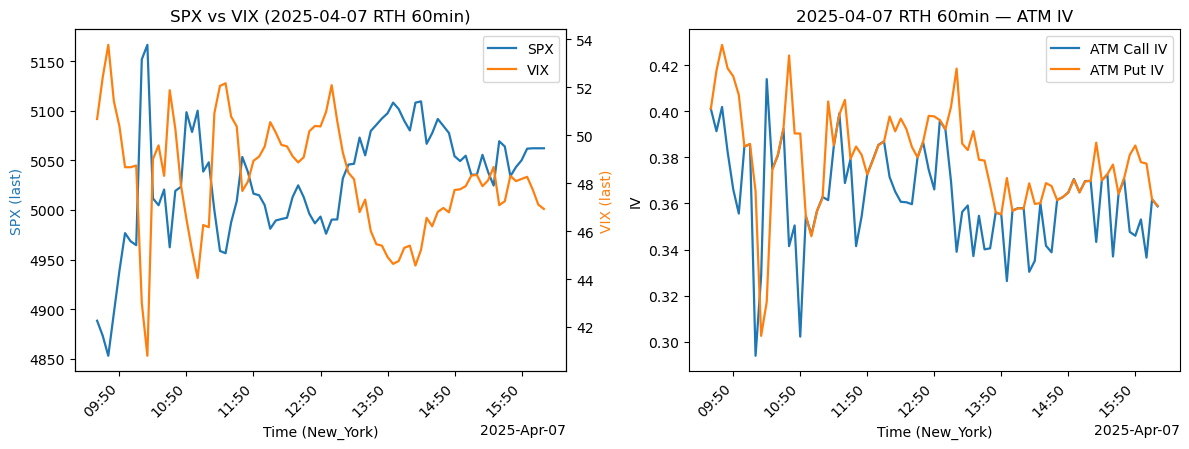

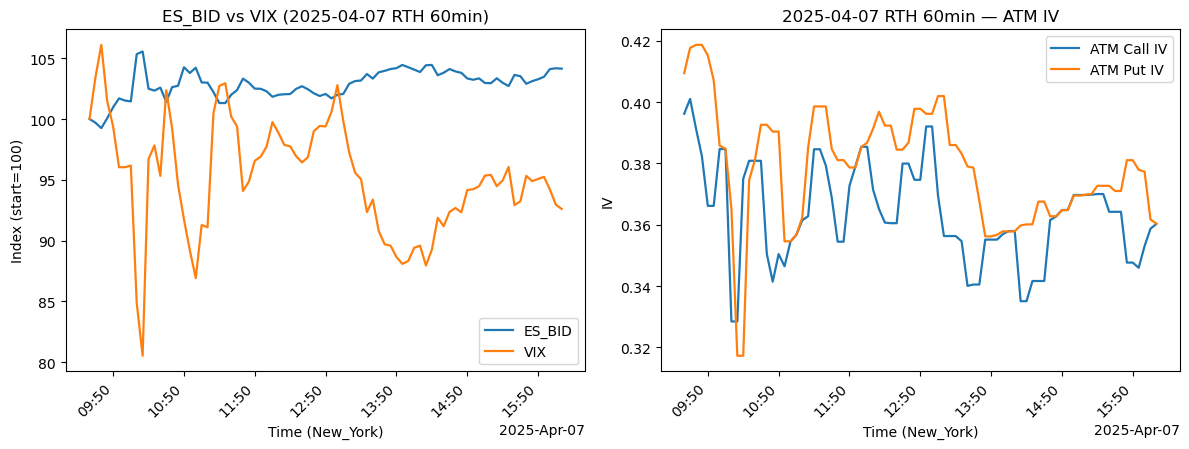

In [9]:
DATE, SESSION, INTERVAL = "2025-04-07", "RTH", "5min"
DERIVED = Path("derived_csv")
iv_path = DERIVED / f"{DATE}_iv_{INTERVAL}_{SESSION}.csv"

iv_table = pd.read_csv(iv_path)
iv_table["timestamp_bin"] = ensure_tz(iv_table["timestamp_bin"])
iv_ok = iv_table[iv_table["iv_flag"]=="ok"].copy()

# 1) Default (dual-axis, SPX vs VIX on left; ATM IV on right)
plot_assets_vs_vix_and_atm_iv(
    assets_agg, iv_ok,
    ref_symbol="SPX",
    date_label=DATE, session_label=SESSION, interval_label="60min"
)

# 2) Use ES_BID and normalize both lines to start=100 for clearer trends
plot_assets_vs_vix_and_atm_iv(
    assets_agg, iv_ok,
    ref_symbol="ES_BID",
    date_label=DATE, session_label=SESSION, interval_label="60min",
    normalize_assets="index",
    smooth_iv=3                              # gentle smoothing on IV
)

### 🧭 How to Read This Implied Volatility Smile Plot

**Purpose**  
These charts show the *implied volatility (IV)* of option contracts across moneyness levels (K/F) at several timestamps throughout the day.  
Each dot represents a call or put option with a specific strike and expiry, with volatility derived from mid-market prices.

---

#### 1️⃣ Axis Meaning (Quant Convention)

We define **log-moneyness**

$$k = \ln\left(\frac{K}{F}\right)$$


- \( k < 0 \) → strike below forward → *OTM calls / ITM puts*  
- \( k = 0 \) → at-the-money (ATM)  
- \( k > 0 \) → strike above forward → *OTM puts / ITM calls*

The x-axis tick labels show \( K/F \) (≈ moneyness ratio), while the underlying math uses the logarithmic scale \( k \).

---

#### 2️⃣ How to Interpret the Shapes

- **Smile or Skew:**  
  The IV curve often slopes downward from left to right (equity markets typically show a *negative skew* — higher IV for downside puts).  
- **PUTs:** IV tends to rise sharply for deep OTM puts (right side, \( K/F > 1 \)).  
- **CALLs:** IV is flatter or slightly increasing for OTM calls (right side).  
- The vertical dashed line at \( K/F = 1.0 \) marks the ATM region.

---

#### 3️⃣ Intraday Comparison

Each color represents a timestamp (New York time).  
- A shift **upward** → overall volatility expansion.  
- A *flatter* smile → reduced skew or stabilized implied vol surface.  
- Comparing early (blue) vs. late (red) curves shows how the market reprices tail risk through the day.

---

#### 4️⃣ Market Convention Note

This chart follows the **academic / quantitative convention** (increasing \( K/F \) → right).  
Traders sometimes mirror puts so both sides “open outward,” but for modeling and calibration work  
(e.g., Heston, SABR, VolGAN), this canonical form is standard.


C:\Users\ShiyunSu\AppData\Local\Temp\ipykernel_12724\2435937902.py:568: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["timestamp_bin","option_type"], group_keys=False).apply(_trim)


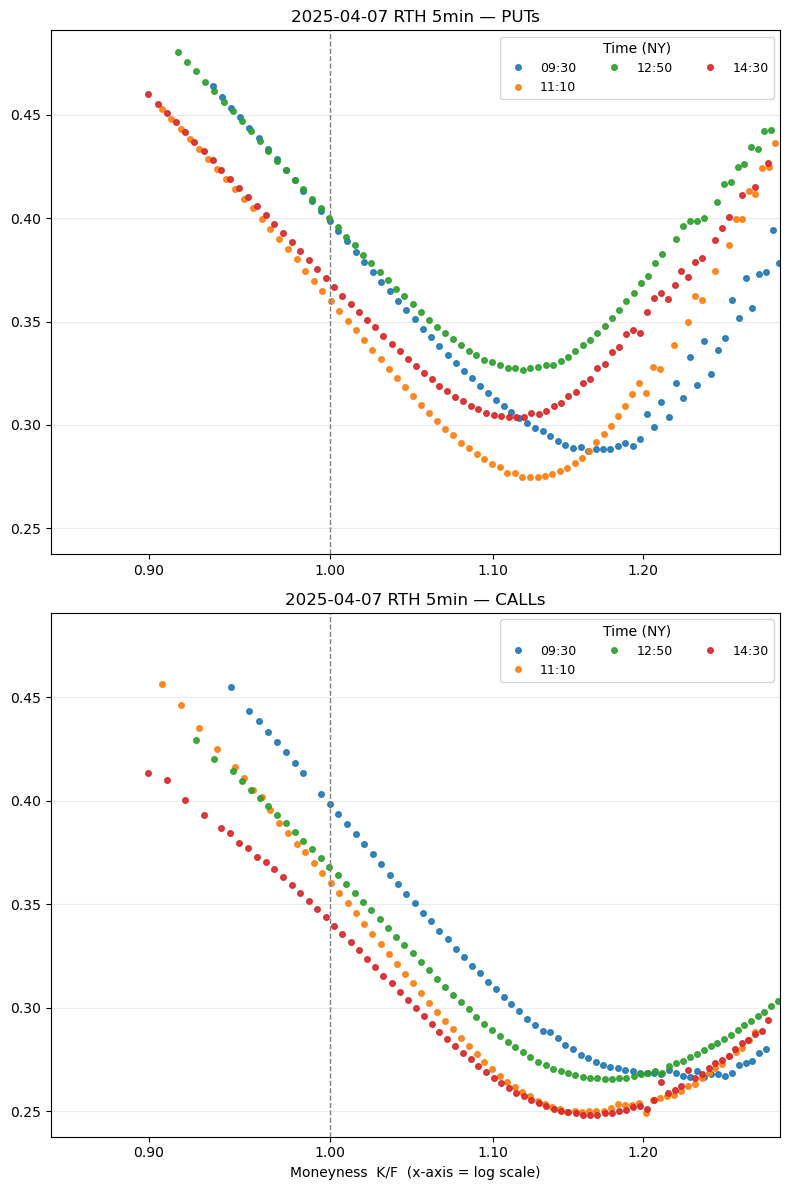

In [10]:
# 3–4 evenly spaced bars from a 5-min day
times = iv_ok["timestamp_bin"].sort_values().unique()
when_list = list(times[0:-1:20])[:4]

# Quant-convention (recommended default)
plot_smiles_split_pc(
    iv_ok, when_list,
    k_range=(np.log(0.85), np.log(1.30)),
    min_iv=0.01,
    title_prefix=f"{DATE} {SESSION} {INTERVAL}",
    unify_forward=True,
    spread_trim_q=0.95
)

# # Trader-view (optional): puts mirrored so both wings “open” the same way
# plot_smiles_split_pc(
#     iv_ok, when_list,
#     k_range=(np.log(0.9), np.log(1.25)),
#     min_iv=0.01,
#     title_prefix=f"{DATE} {SESSION} {INTERVAL} (Trader view)",
#     trader_view=True,            # << only changes the picture, not the data
#     unify_forward=True,
#     spread_trim_q=0.95
# )


### Use the above codes and play around with different dates and time, we can pick and zoom into interesting moves...

Main Timeline: https://www.betashares.com.au/insights/liberation-day-upended-markets/

2 Apr 4PM ET - Trump Tariff announcement followed with relatively controlled decline until 4 Apr 6AM ET

4 Apr 6AM ET - China's retaliation on Friday before weekend (https://www.cnbc.com/2025/04/03/stock-market-today-live-updates.html)

6 Apr 8AM ET - Monday Asian opening hours (7Apr SGT 6AM) observe ES huge gap down and VIX peaked at 60 (https://www.reuters.com/markets/us/us-investors-braced-more-volatility-bumps-ahead-monday-trading-open-2025-04-06/)

7 Apr 10AM ET - 9% SPX Moves on Fake News! $2 trillion in buying in just eight minutes (https://edition.cnn.com/2025/04/07/media/fake-news-x-post-caused-market-whiplash/index.html)

9 Apr 12PM ET - 90-Day Tariff Pause Announcement (Note: Hours before making the announcement, Trump said “THIS IS A GREAT TIME TO BUY!!!”)